#Transformer Data Pipeline and Predictive Analysis

## Data Pipeline  
- Data ingestion from Supabase and Open-Meteo API (via transformer-weather-ingest: https://github.com/stephengilbert1/transformer-weather-ingest)  
- Data cleaning and integration

## Exploratory Data Analysis  
- Visualization of internal and ambient temperatures  
- Correlation analysis

## Predictive Modeling  
- Linear regression and forecasting transformer temperature  
- Model evaluation and applications

## Conclusion and Next Steps  
- Pipeline automation, deployment ideas, and model improvements

#Setup and Imports

Load libraries, environment variables, and configure plot styles

In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json



from datetime import datetime, timedelta, timezone
from pathlib import Path
from supabase import create_client
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

load_dotenv()

# --- Style defaults for consistency with portfolio ---
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Outfit", "Arial", "Helvetica", "DejaVu Sans"]
plt.rcParams["figure.facecolor"] = "#ffffff"
plt.rcParams["axes.facecolor"] = "#ffffff"
plt.rcParams["text.color"] = "#171717"
plt.rcParams["axes.labelcolor"] = "#171717"
plt.rcParams["xtick.color"] = "#171717"
plt.rcParams["ytick.color"] = "#171717"



SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SERVICE_ROLE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

## Data Loading

This function will load transformer temperature readings and ambient temperature data from Supabase.
Transformer temperature data is generated by a vercel triggered cron job. This data is shared by the Transformer Dashboard application.
Ambient temperature data is obtained via the transformer-weather-ingest tool from Open-Meteo API. The database will likely have stale or missing ambient temperature data unless this tool has been executed recently.

In [69]:
def fetch_readings_from_supabase(days: int = 30, page_size: int = 1000, max_rows: int | None = None):
    client = create_client(SUPABASE_URL, SUPABASE_SERVICE_ROLE_KEY)
    since = (datetime.now(timezone.utc) - timedelta(days=days))\
        .isoformat(timespec="seconds").replace("+00:00", "Z")

    rows, offset = [], 0
    while True:
        q = (
            client.table("temperature_readings")      # or .postgrest.from_(...)
                  .select("transformer_id,timestamp,tempC, ambient_temperature")
                  .gte("timestamp", since)
                  .order("timestamp", desc=False)
                  .range(offset, offset + page_size - 1)
        )
        try:
            res = q.execute()
        except Exception as e:
            raise RuntimeError(f"Supabase fetch failed: {e}") from e

        batch = res.data or []
        rows.extend(batch)

        # stop conditions
        if len(batch) < page_size:
            break
        offset += page_size
        if max_rows and len(rows) >= max_rows:
            rows = rows[:max_rows]
            break

    return rows

DATA_PATH = Path("../data/readings.csv")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True)
OVERHEAT_THRESHOLD = float(os.getenv("OVERHEAT_THRESHOLD", "100"))


## Data Fetching and Cleaning

In this step, we fetch the latest 30 days of transformer temperature data and ambient temperature from Supabase.  
We convert timestamps to datetime format, print basic info about the fetched data, and clean it by removing rows with missing temperature values.


In [70]:
rows = fetch_readings_from_supabase(days=30, page_size=1000, max_rows=100000)
df = pd.DataFrame(rows)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
print("Fetched rows:", len(df))
print("time span:", df["timestamp"].min(), "→", df["timestamp"].max(), f"({len(df)} rows)")
df = df.sort_values("timestamp").dropna(subset=["tempC", "ambient_temperature"]).reset_index(drop=True)
df.head()
print(df[["tempC", "ambient_temperature"]].describe())

Fetched rows: 19926
time span: 2025-07-21 06:00:00+00:00 → 2025-08-20 23:00:00+00:00 (19926 rows)
             tempC  ambient_temperature
count  7376.000000          7376.000000
mean     79.937801            18.863015
std      15.296081             3.596392
min      48.640000            10.500000
25%      67.050000            16.000000
50%      79.965000            18.400000
75%      92.662500            21.200000
max     110.980000            29.600000


## Linear Regression Modeling

We use a simple linear regression model to predict transformer internal temperature (`tempC`) based on ambient temperature.  
This model will help us understand the relationship between ambient and internal temperatures and evaluate how well ambient temperature alone can explain internal temperature variations.


Linear regression coefficient (slope): 3.087
Intercept: 21.707
R^2 score: 0.527
Model equation: internal_temperature = 21.707 + 3.087 * ambient_temperature


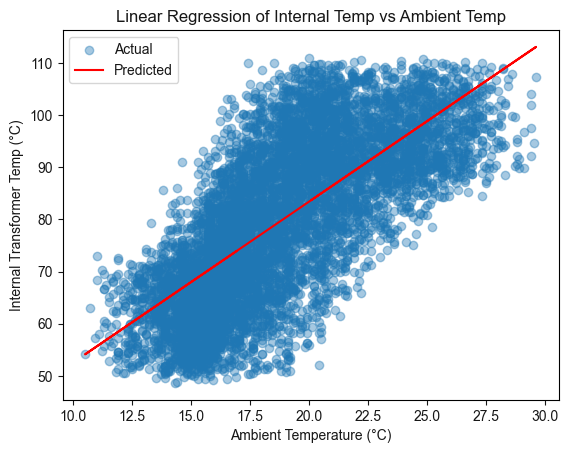

In [71]:


# Prepare X and y from cleaned df
X = df[['ambient_temperature']].values  # Predictor
y = df['tempC'].values                   # Response (internal temp)

model = LinearRegression()
model.fit(X, y)

df['predicted_tempC'] = model.predict(X)

print(f"Linear regression coefficient (slope): {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")
print(f"R^2 score: {r2_score(y, df['predicted_tempC']):.3f}")

print(f"Model equation: internal_temperature = {model.intercept_:.3f} + {model.coef_[0]:.3f} * ambient_temperature")

# Plot results for quick visualization
plt.scatter(df['ambient_temperature'], df['tempC'], alpha=0.4, label='Actual')
plt.plot(df['ambient_temperature'], df['predicted_tempC'], color='red', label='Predicted')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Internal Transformer Temp (°C)')
plt.legend()
plt.title("Linear Regression of Internal Temp vs Ambient Temp")
plt.show()

### Summary Statistics per Transformer

First, we ensure transformer IDs are strings for consistency.  
Then, we compute key summary statistics per transformer, including average and maximum internal temperatures, and the count of temperature readings.


In [72]:
# --- Ensure IDs are strings BEFORE any groupbys/joins ---
df["transformer_id"] = df["transformer_id"].astype(str)

# 1) Summary per transformer (avg/max/count)
summary = (
    df.groupby("transformer_id", as_index=True)
      .agg(
          avg_temp=("tempC", "mean"),
          max_temp=("tempC", "max"),
          count=("tempC", "size"),
      )
      .round(2)
)
summary.head()

,avg_temp,max_temp,count
transformer_id,,,
XFMR-0001,79.97,110.07,738
XFMR-0002,79.91,110.98,738
XFMR-0003,80.24,110.68,737
XFMR-0004,80.10,109.92,738
XFMR-0005,79.91,109.69,738


### Calculating Hours Above Threshold

We define a helper function using linear interpolation to calculate the number of hours each transformer’s temperature stayed above the defined overheating threshold within a specified time window.


In [73]:
def hours_over_threshold_window(g: pd.DataFrame, thresh: float,
                                start: pd.Timestamp, end: pd.Timestamp) -> float:
    s = g[["timestamp", "tempC"]].dropna().sort_values("timestamp")
    if len(s) < 2:
        return 0.0
    t0 = s["timestamp"].astype("int64").to_numpy() / 1e9
    t1 = s["timestamp"].shift(-1).astype("int64").to_numpy() / 1e9
    y0 = s["tempC"].to_numpy(dtype=float)
    y1 = s["tempC"].shift(-1).to_numpy(dtype=float)
    mask = ~np.isnan(t1)
    t0, t1, y0, y1 = t0[mask], t1[mask], y0[mask], y1[mask]
    if t0.size == 0:
        return 0.0

    start_s = start.value / 1e9
    end_s   = end.value   / 1e9
    sel = (t1 > start_s) & (t0 < end_s)
    if not np.any(sel):
        return 0.0
    t0, t1, y0, y1 = t0[sel], t1[sel], y0[sel], y1[sel]
    ts = np.maximum(t0, start_s)
    te = np.minimum(t1, end_s)

    denom = (t1 - t0)
    denom[denom == 0.0] = np.nan
    m = (y1 - y0) / denom  # °C/s

    above_ms = np.zeros_like(ts)

    both_above = (y0 > thresh) & (y1 > thresh)
    above_ms[both_above] = (te[both_above] - ts[both_above]) * 1000

    crossing = ((y0 > thresh) ^ (y1 > thresh)) & np.isfinite(m)
    if np.any(crossing):
        t_cross = t0[crossing] + (thresh - y0[crossing]) / m[crossing]
        falling = (y0[crossing] > thresh) & (y1[crossing] <= thresh)
        rising  = ~falling
        t_left  = np.maximum(ts[crossing], t_cross)
        t_right = np.minimum(te[crossing], t_cross)
        above_ms[crossing][falling] += np.maximum(0, (t_right[falling] - ts[crossing][falling]) * 1000)
        above_ms[crossing][rising]  += np.maximum(0, (te[crossing][rising] - t_left[rising]) * 1000)

    return float(above_ms.sum() / 3_600_000.0)  # ms -> hours


### Hours Over Temperature Threshold Across Time Windows

Using the function above, we compute how many hours each transformer’s temperature exceeded the overheating threshold in the last 24 hours, 7 days, and 30 days.


In [74]:
now_utc   = pd.Timestamp.now(tz="UTC")
start_24h = now_utc - pd.Timedelta(hours=24)
start_7d  = now_utc - pd.Timedelta(days=7)
start_30d = now_utc - pd.Timedelta(days=30)

over_24h = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_24h, now_utc))
      .rename("hours_over_thresh_24h")
)
over_7d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_7d,  now_utc))
      .rename("hours_over_thresh_7d")
)
over_30d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_30d, now_utc))
      .rename("hours_over_thresh_30d")
)

### Combined Risk Summary and Export

We join the summary statistics with the hours-over-threshold metrics to create a comprehensive risk table.  
This table is saved as a CSV file for further reporting and analysis.


In [75]:
risk = (
    summary
    .join(over_24h).join(over_7d).join(over_30d)
    .fillna(0)
)
risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]] = \
    risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]].astype(float).round(2)

risk.to_csv(OUT_DIR / "hot_transformers.csv")
print("Saved:", OUT_DIR / "hot_transformers.csv")

Saved: ..\outputs\hot_transformers.csv


### Preparing Data Payload for Web Visualization

Finally, we build a compact JSON dataset that includes time series temperatures and hours-over-threshold metrics per transformer.  
This JSON file can be consumed by web applications or dashboards for monitoring transformer health.

In [76]:
hours24_map = over_24h.to_dict()
hours7d_map = over_7d.to_dict()
hours30_map = over_30d.to_dict()

g = (
    df.loc[:, ["transformer_id", "timestamp", "tempC", "ambient_temperature"]]
      .dropna(subset=["timestamp", "tempC"])
      .sort_values("timestamp")
)

payload = {}
for tid, chunk in g.groupby("transformer_id", sort=True):
    ts = chunk["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    payload[tid] = {
        "t": ts.tolist(),
        "y": chunk["tempC"].astype(float).round(2).tolist(),
        "ambient": chunk["ambient_temperature"].astype(float).round(2).tolist(),
        "h": {
            "24h": round(float(hours24_map.get(tid, 0.0)), 3),
            "7d":  round(float(hours7d_map.get(tid, 0.0)), 3),
            "30d": round(float(hours30_map.get(tid, 0.0)), 3),
        },
    }

out_json = OUT_DIR / "series.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(payload, f, separators=(",", ":"))
print(
    f"Wrote {out_json} with {len(payload)} transformers and "
    f"{sum(len(v['t']) for v in payload.values())} total points."
)


Wrote ..\outputs\series.json with 10 transformers and 7376 total points.


### Time Series for a Single Transformer

We select one transformer (either from the risk summary or the dataset) and prepare its temperature data over time.  
A 6-hour rolling average is computed to smooth short-term fluctuations.


In [77]:
t_id = risk.index[0] if len(risk.index) else df["transformer_id"].iloc[0]
df_one = df[df["transformer_id"] == t_id].copy().sort_values("timestamp")
df_one["rolling_6h"] = df_one["tempC"].rolling(window=6, min_periods=1).mean()

### Visualizing Transformer Temperature Trends

We plot the raw top-oil temperature and the 6-hour rolling average over time for the selected transformer, highlighting overall trends.


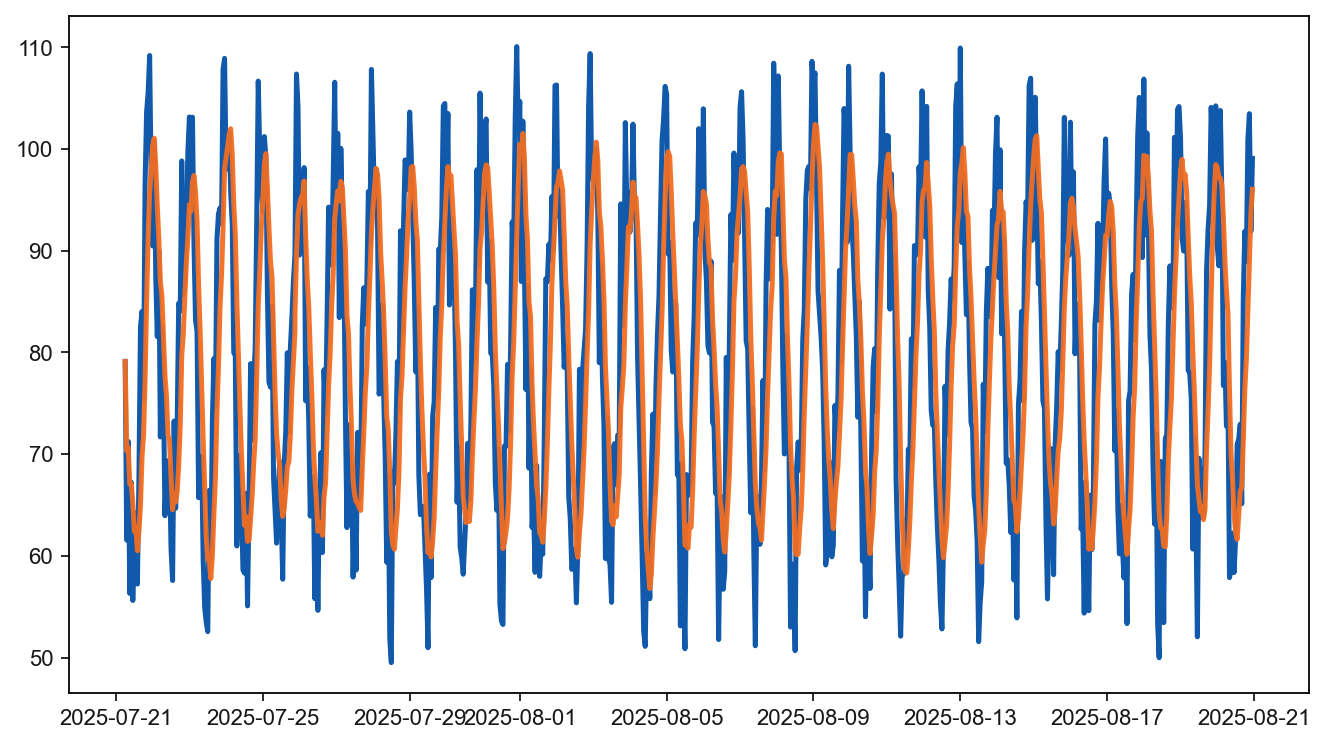

In [78]:
fig, ax = plt.subplots(figsize=(10, 5.5), dpi=160)

# Main series
ax.plot(df_one["timestamp"], df_one["tempC"], linewidth=2.25,
        label=f"{t_id} Top-Oil", color="#1059ab")

# Rolling average
ax.plot(df_one["timestamp"], df_one["rolling_6h"], linewidth=2.25,
        label="6-hr avg", color="#f26d21", alpha=0.95)

### Overheating Threshold and Exceedance Highlights

We add a horizontal line representing the overheating threshold and shade the periods where the temperature exceeds this limit.


In [79]:
# Threshold
ax.axhline(OVERHEAT_THRESHOLD, linestyle="--", linewidth=2, color="red",
           label=f"Threshold ({OVERHEAT_THRESHOLD:.0f}°C)")

# Shade exceedances
ax.fill_between(df_one["timestamp"], df_one["tempC"], OVERHEAT_THRESHOLD,
                where=(df_one["tempC"] > OVERHEAT_THRESHOLD),
                alpha=0.12, color="red", interpolate=True)

### Annotating the Peak Temperature

We highlight the highest temperature observed with an annotation and arrow for clear emphasis.


In [80]:
if not df_one.empty:
    imax = df_one["tempC"].idxmax()
    ax.annotate(
        f"Peak {df_one.loc[imax,'tempC']:.1f}°C",
        xy=(df_one.loc[imax, "timestamp"], df_one.loc[imax, "tempC"]),
        xytext=(20, 30), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=1, color="#171717"),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.85)
    )

### Finishing Touches and Saving

We clean up the plot by removing unnecessary spines, adding gridlines, formatting dates, and placing the legend outside for better clarity.  
Finally, we save the figure in PNG and SVG formats for portfolio use.


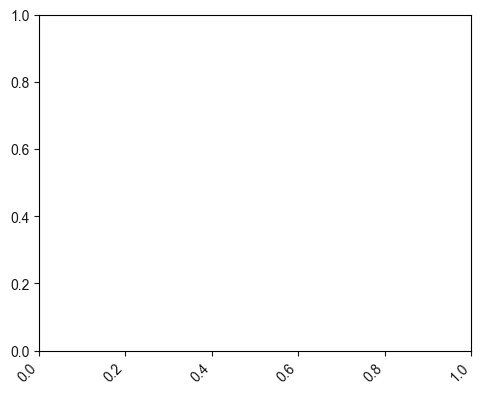

In [81]:


# Labels, grid, axes cleanup
ax.set_title(f"{t_id} — Top-Oil Temperature", fontsize=14, pad=10)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)

# Date formatting and spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%b"))
plt.xticks(rotation=45, ha="right")
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 1, ymax)

# Legend OUTSIDE to the right
leg = ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# Make room for the outside legend
plt.subplots_adjust(right=0.8, bottom=0.18)

# Save PNG + SVG (crisp for portfolio)
fig.savefig(OUT_DIR / "trend_1.png", dpi=200, bbox_inches="tight")
fig.savefig(OUT_DIR / "trend_1.svg", bbox_inches="tight")
plt.show()
